In [8]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json 
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

In [10]:
sample = glob('/content/drive/MyDrive/Dacon/PlantDisease/train/train/*')[200]

sample_csv = pd.read_csv(glob(sample+'/*.csv')[0])
sample_image = cv2.imread(glob(sample+'/*.jpg')[0])
sample_json = json.load(open(glob(sample+'/*.json')[0], 'r'))

In [11]:
# csv
sample_csv

,측정시각,내부 온도 1 평균,내부 온도 1 최고,내부 온도 1 최저,내부 온도 2 평균,내부 온도 2 최고,내부 온도 2 최저,내부 온도 3 평균,내부 온도 3 최고,내부 온도 3 최저,내부 온도 4 평균,내부 온도 4 최고,내부 온도 4 최저,내부 습도 1 평균,내부 습도 1 최고,내부 습도 1 최저,내부 습도 2 평균,내부 습도 2 최고,내부 습도 2 최저,내부 습도 3 평균,내부 습도 3 최고,내부 습도 3 최저,내부 습도 4 평균,내부 습도 4 최고,내부 습도 4 최저,내부 이슬점 평균,내부 이슬점 최고,내부 이슬점 최저,내부 CO2 평균,내부 CO2 최고,내부 CO2 최저,외부 풍속 평균,외부 풍속 최고,외부 풍속 최저,내부 EC 1 평균,내부 EC 1 최고,내부 EC 1 최저,내부 PH 1 평균,내부 PH 1 최고,내부 PH 1 최저,배지 중량 평균,배지 중량 최고,배지 중량 최저,양액 온도 평균,양액 온도 최고,양액 온도 최저,외부 풍향 수치,외부 풍향,외부 빗물 시간,외부 누적일사 평균,양액 급액 누적,양액 배액 누적
0,2021-07-06 09:30:00,25.9,26.0,25.9,-,-,-,-,-,-,-,-,-,82.7,83.3,82.1,-,-,-,-,-,-,-,-,-,22.8,22.9,22.7,410.5,412.0,407.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
1,2021-07-06 09:20:00,25.8,26.1,25.6,-,-,-,-,-,-,-,-,-,83.6,84.6,83.0,-,-,-,-,-,-,-,-,-,23.1,23.3,22.9,409.4,413.0,405.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
2,2021-07-06 09:10:00,25.7,25.7,25.6,-,-,-,-,-,-,-,-,-,84.0,84.8,83.2,-,-,-,-,-,-,-,-,-,23.1,23.3,22.9,414.3,419.0,408.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
3,2021-07-06 09:00:00,25.6,25.6,25.5,-,-,-,-,-,-,-,-,-,84.2,85.3,83.7,-,-,-,-,-,-,-,-,-,23.1,23.3,23.1,423.3,426.0,420.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
4,2021-07-06 08:50:00,25.4,25.5,25.2,-,-,-,-,-,-,-,-,-,85.5,86.8,84.6,-,-,-,-,-,-,-,-,-,22.6,23.3,22.3,430.0,435.0,426.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,2021-07-04 09:20:00,24.6,24.8,24.4,-,-,-,-,-,-,-,-,-,86.2,87.5,85.1,-,-,-,-,-,-,-,-,-,22.4,22.9,21.3,393.6,397.0,388.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
290,2021-07-04 09:10:00,25.0,25.1,24.8,-,-,-,-,-,-,-,-,-,86.2,87.2,85.5,-,-,-,-,-,-,-,-,-,22.5,22.7,22.5,395.5,397.0,392.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
291,2021-07-04 09:00:00,25.1,25.2,24.9,-,-,-,-,-,-,-,-,-,87.6,88.8,86.1,-,-,-,-,-,-,-,-,-,22.8,23.1,22.5,399.4,407.0,392.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
292,2021-07-04 08:50:00,24.5,24.8,24.1,-,-,-,-,-,-,-,-,-,89.8,90.4,88.9,-,-,-,-,-,-,-,-,-,22.7,23.2,22.3,410.3,418.0,402.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


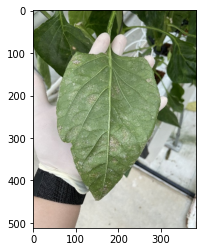

In [12]:
# image
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.show()

In [13]:
# json
sample_json

{'annotations': {'area': 3,
  'bbox': [{'h': 363.0966021825397,
    'w': 244.85077194940476,
    'x': 53.64922805059524,
    'y': 85.12499224950396}],
  'crop': 3,
  'disease': 'a9',
  'grow': 13,
  'part': [{'h': 40.125, 'id': 0, 'w': 38.0625, 'x': 104.625, 'y': 172.875},
   {'h': 39.0, 'id': 1, 'w': 34.5, 'x': 78.0, 'y': 270.75},
   {'h': 43.875, 'id': 2, 'w': 27.75, 'x': 114.1875, 'y': 342.9375},
   {'h': 42.1875, 'id': 3, 'w': 28.5, 'x': 178.125, 'y': 295.3125},
   {'h': 37.875, 'id': 4, 'w': 30.375, 'x': 143.625, 'y': 291.75},
   {'h': 27.375, 'id': 5, 'w': 34.125, 'x': 97.875, 'y': 292.875},
   {'h': 29.25, 'id': 6, 'w': 31.5, 'x': 123.75, 'y': 197.0625},
   {'h': 35.25, 'id': 7, 'w': 24.1875, 'x': 180.9375, 'y': 172.3125},
   {'h': 25.87500775049603,
    'id': 8,
    'w': 29.8125,
    'x': 83.4375,
    'y': 104.24999224950396},
   {'h': 29.625, 'id': 9, 'w': 25.125, 'x': 202.875, 'y': 281.625},
   {'h': 30.375, 'id': 10, 'w': 24.375, 'x': 81.75, 'y': 216.0},
   {'h': 33.5625, 'i

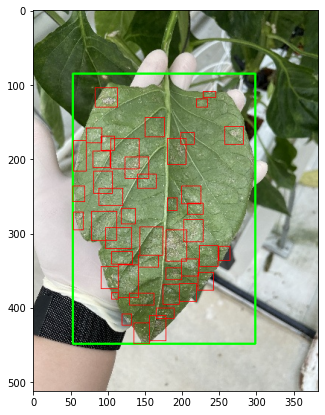

In [14]:
# visualize bbox
plt.figure(figsize=(7,7))
points = sample_json['annotations']['bbox'][0]
part_points = sample_json['annotations']['part']
img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

cv2.rectangle(
    img,
    (int(points['x']), int(points['y'])),
    (int((points['x']+points['w'])), int((points['y']+points['h']))),
    (0, 255, 0),
    2
)
for part_point in part_points:
    point = part_point
    cv2.rectangle(
        img,
        (int(point['x']), int(point['y'])),
        (int((point['x']+point['w'])), int((point['y']+point['h']))),
        (255, 0, 0),
        1
    )
plt.imshow(img)
plt.show()

In [21]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저'] #, '내부 CO2 평균','내부 CO2 최고', '내부 CO2 최저']

csv_files = sorted(glob('/content/drive/MyDrive/Dacon/PlantDisease/train/train/*/*.csv'))

temp_csv = pd.read_csv(csv_files[0])[csv_features]
max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()

# feature 별 최대값, 최솟값 계산
for csv in tqdm(csv_files[1:]):
    temp_csv = pd.read_csv(csv)[csv_features]
    temp_csv = temp_csv.replace('-',np.nan).dropna()
    if len(temp_csv) == 0:
        continue
    temp_csv = temp_csv.astype(float)
    temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
    max_arr = np.max([max_arr,temp_max], axis=0)
    min_arr = np.min([min_arr,temp_min], axis=0)

# feature 별 최대값, 최솟값 dictionary 생성
csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}
csv_feature_dict

100%|██████████| 5766/5766 [23:23<00:00,  4.11it/s]


{'내부 습도 1 최고': [25.9, 100.0],
 '내부 습도 1 최저': [0.0, 100.0],
 '내부 습도 1 평균': [23.7, 100.0],
 '내부 온도 1 최고': [3.4, 47.6],
 '내부 온도 1 최저': [3.3, 47.0],
 '내부 온도 1 평균': [3.4, 47.3],
 '내부 이슬점 최고': [0.2, 34.7],
 '내부 이슬점 최저': [0.0, 34.4],
 '내부 이슬점 평균': [0.1, 34.5]}

In [22]:
# 변수 설명 csv 파일 참조
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}
risk = {'1':'초기','2':'중기','3':'말기'}

In [23]:
label_description = {}
for key, value in disease.items():
    label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
    for disease_code in value:
        for risk_code in risk:
            label = f'{key}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'
list(label_description.items())[:10]

[('1_00_0', '딸기_정상'),
 ('1_a1_1', '딸기_딸기잿빛곰팡이병_초기'),
 ('1_a1_2', '딸기_딸기잿빛곰팡이병_중기'),
 ('1_a1_3', '딸기_딸기잿빛곰팡이병_말기'),
 ('1_a2_1', '딸기_딸기흰가루병_초기'),
 ('1_a2_2', '딸기_딸기흰가루병_중기'),
 ('1_a2_3', '딸기_딸기흰가루병_말기'),
 ('1_b1_1', '딸기_냉해피해_초기'),
 ('1_b1_2', '딸기_냉해피해_중기'),
 ('1_b1_3', '딸기_냉해피해_말기')]

In [24]:
label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

In [26]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train'):
        self.mode = mode
        self.files = files
        self.csv_feature_dict = csv_feature_dict
        self.csv_feature_check = [0]*len(self.files)
        self.csv_features = [None]*len(self.files)
        self.max_len = 24 * 6
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('/')[-1]
        
        # csv
        if self.csv_feature_check[i] == 0:
            csv_path = f'{file}/{file_name}.csv'
            df = pd.read_csv(csv_path)[self.csv_feature_dict.keys()]
            df = df.replace('-', 0)
            # MinMax scaling
            for col in df.columns:
                df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
                df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
            # zero padding
            pad = np.zeros((self.max_len, len(df.columns)))
            length = min(self.max_len, len(df))
            pad[-length:] = df.to_numpy()[-length:]
            # transpose to sequential data
            csv_feature = pad.T
            self.csv_features[i] = csv_feature
            self.csv_feature_check[i] = 1
        else:
            csv_feature = self.csv_features[i]
        
        # image
        image_path = f'{file}/{file_name}.jpg'
        img = cv2.imread(image_path)
        img = cv2.resize(img, dsize=(256, 256), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32)/255
        img = np.transpose(img, (2,0,1))
        
        if self.mode == 'train':
            json_path = f'{file}/{file_name}.json'
            with open(json_path, 'r') as f:
                json_file = json.load(f)
            
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'
            
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
            }
        else:
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32)
            }

In [27]:
device = torch.device("cuda:0")
batch_size = 64
class_n = len(label_encoder)
learning_rate = 1e-3
embedding_dim = 512
num_features = len(csv_feature_dict)
max_len = 24*6
dropout_rate = 0.1
epochs = 10
vision_pretrain = True
save_path = 'best_model.pt'

In [28]:
# data loader

train = sorted(glob('/content/drive/MyDrive/Dacon/PlantDisease/train/train/*'))
test = sorted(glob('/content/drive/MyDrive/Dacon/PlantDisease/test/test/*'))

labelsss = pd.read_csv('/content/drive/MyDrive/Dacon/PlantDisease/train.csv')['label']
train, val = train_test_split(train, test_size=0.2, stratify=labelsss)

In [ ]:
folds = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_idx, valid_idx in kf.split(imgs):
    folds.append((train_idx, valid_idx))
fold=0
train_idx, valid_idx = folds[fold]

batch_size = 16
epochs = 30


train_dataset = Custom_dataset(np.array(imgs)[train_idx], np.array(labels)[train_idx], mode='train')
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, pin_memory=True, num_workers=3)

        
valid_dataset = Custom_dataset(np.array(imgs)[valid_idx], np.array(labels)[valid_idx], mode='valid')
valid_loader = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size, pin_memory=True, num_workers=3)

In [ ]:
train_dataset = CustomDataset(train)
val_dataset = CustomDataset(val)
test_dataset = CustomDataset(test, mode = 'test')

train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size, pin_memory=True, num_workers=3)
val_dataloader = torch.utils.data.DataLoader(val_dataset, shuffle=False, batch_size=batch_size, pin_memory=True, num_workers=3)
test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=batch_size, num_workers=3)

In [ ]:
# image classification
class CNN_Encoder(nn.Module):
    def __init__(self, class_n, rate=0.1):
        super(CNN_Encoder, self).__init__()
        self.model = models.efficientnet_b0(pretrained=True)
    
    def forward(self, inputs):
        output = self.model(inputs)
        return output

In [ ]:
# timeseries :  LSTM
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(RNN_Decoder, self).__init__()
        self.lstm = nn.LSTM(max_len, embedding_dim)
        self.rnn_fc = nn.Linear(num_features*embedding_dim, 1000)
        self.final_layer = nn.Linear(1000 + 1000, class_n) # resnet out_dim + lstm out_dim
        self.dropout = nn.Dropout(rate)

    def forward(self, enc_out, dec_inp):
        hidden, _ = self.lstm(dec_inp)
        hidden = hidden.view(hidden.size(0), -1)
        hidden = self.rnn_fc(hidden)
        concat = torch.cat([enc_out, hidden], dim=1) # enc_out + hidden 
        fc_input = concat
        output = self.dropout((self.final_layer(fc_input)))
        return output

In [ ]:
# Ansemble

class CNN2RNN(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_features, class_n, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        
        return output

In [ ]:
model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model = model.to(device)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score

def train_step(batch_item, training):
    img = batch_item['img'].to(device)
    csv_feature = batch_item['csv_feature'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        score = accuracy_function(label, output)
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        score = accuracy_function(label, output)
        return loss, score

In [ ]:
loss_plot, val_loss_plot = [], []
metric_plot, val_metric_plot = [], []

for epoch in range(epochs):
    total_loss, total_val_loss = 0, 0
    total_acc, total_val_acc = 0, 0
    
    tqdm_dataset = tqdm(enumerate(train_dataloader))
    training = True
    
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_loss += batch_loss
        total_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Loss' : '{:06f}'.format(total_loss/(batch+1)),
            'Mean F-1' : '{:06f}'.format(total_acc/(batch+1))
        })
    loss_plot.append(total_loss/(batch+1))
    metric_plot.append(total_acc/(batch+1))
    
    tqdm_dataset = tqdm(enumerate(val_dataloader))
    training = False
    for batch, batch_item in tqdm_dataset:
        batch_loss, batch_acc = train_step(batch_item, training)
        total_val_loss += batch_loss
        total_val_acc += batch_acc
        
        tqdm_dataset.set_postfix({
            'Epoch': epoch + 1,
            'Val Loss': '{:06f}'.format(batch_loss.item()),
            'Mean Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
            'Mean Val F-1' : '{:06f}'.format(total_val_acc/(batch+1))
        })
    val_loss_plot.append(total_val_loss/(batch+1))
    val_metric_plot.append(total_val_acc/(batch+1))
    
    if np.max(val_metric_plot) == val_metric_plot[-1]:
        torch.save(model.state_dict(), save_path)

37it [03:37,  5.88s/it, Epoch=1, Loss=2.299850, Mean Loss=2.173692, Mean F-1=0.244563]
10it [01:31,  9.10s/it, Epoch=1, Val Loss=0.963783, Mean Val Loss=0.758031, Mean Val F-1=0.570264]
37it [00:55,  1.49s/it, Epoch=2, Loss=1.025513, Mean Loss=0.925544, Mean F-1=0.543129]
10it [00:15,  1.51s/it, Epoch=2, Val Loss=0.701097, Mean Val Loss=0.423388, Mean Val F-1=0.645666]
37it [00:55,  1.50s/it, Epoch=3, Loss=0.690102, Mean Loss=0.661946, Mean F-1=0.648336]
10it [00:14,  1.45s/it, Epoch=3, Val Loss=0.852036, Mean Val Loss=0.337033, Mean Val F-1=0.738784]
37it [00:54,  1.48s/it, Epoch=4, Loss=1.227881, Mean Loss=0.585105, Mean F-1=0.695430]
10it [00:14,  1.46s/it, Epoch=4, Val Loss=1.252474, Mean Val Loss=0.332205, Mean Val F-1=0.737758]
37it [00:55,  1.50s/it, Epoch=5, Loss=1.088763, Mean Loss=0.441729, Mean F-1=0.672886]
10it [00:14,  1.47s/it, Epoch=5, Val Loss=0.990788, Mean Val Loss=0.260374, Mean Val F-1=0.779656]
37it [00:55,  1.51s/it, Epoch=6, Loss=1.241748, Mean Loss=0.412263, Me

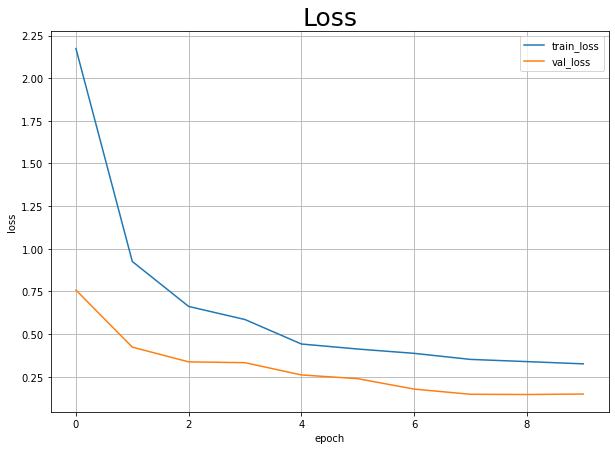

In [ ]:
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(loss_plot, label='train_loss')
plt.plot(val_loss_plot, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss", fontsize=25)
plt.legend()
plt.show()

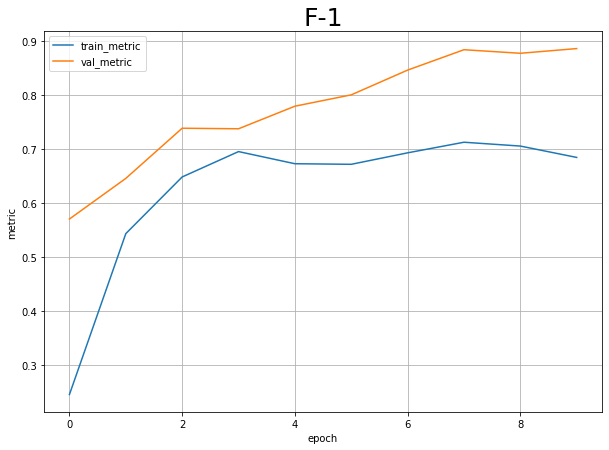

In [ ]:
plt.figure(figsize=(10,7))
plt.grid()
plt.plot(metric_plot, label='train_metric')
plt.plot(val_metric_plot, label='val_metric')
plt.xlabel('epoch')
plt.ylabel('metric')
plt.title("F-1", fontsize=25)
plt.legend()
plt.show()

In [ ]:
def predict(dataset):
    model.eval()
    tqdm_dataset = tqdm(enumerate(dataset))
    results = []
    for batch, batch_item in tqdm_dataset:
        img = batch_item['img'].to(device)
        seq = batch_item['csv_feature'].to(device)
        with torch.no_grad():
            output = model(img, seq)
        output = torch.tensor(torch.argmax(output, dim=1), dtype=torch.int32).cpu().numpy()
        results.extend(output)
    return results

model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model.load_state_dict(torch.load(save_path, map_location=device))
model.to(device)

preds = predict(test_dataloader)

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
4it [00:37,  5.27s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4964d95950>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
8it [01:13,  5.06s/it]Exception ignored in: <function _M

In [ ]:
preds = np.array([label_decoder[int(val)] for val in preds])

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/Dacon/PlantDisease/sample_submission.csv')
submission['label'] = preds
submission

,image,label
0,10000,6_00_0
1,10001,5_b6_1
2,10002,4_00_0
3,10003,3_00_0
4,10004,3_b8_1
...,...,...
51901,67673,4_00_0
51902,67674,3_b7_1
51903,67675,6_00_0
51904,67676,6_00_0


In [ ]:
submission.to_csv('/content/drive/MyDrive/Dacon/PlantDisease/effnetb0_submission.csv', index=False)